## Semantic Search with Dense Vector Embeddings

In [1]:
import sys
import os
sys.path.append("../..")
import copy
import pickle
import numpy
import pandas
from aips import *
from aips.spark import create_view_from_collection
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from aips.data_loaders.outdoors import load_dataframe
import sentence_transformers
import torch

engine = get_engine()
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS").config(conf=conf).getOrCreate()

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load and clean the Outdoors dataset

## Transformer time!

In [2]:
#%run 1.setting-up-the-outdoors-dataset.ipynb

In [3]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
cache_name = "outdoors_semantic_search_embeddings"

In [4]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [5]:
def rank_similarities(phrases, similarities, name=None):
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(similarities) - 1):
        for b in range(a + 1, len(similarities)):
            a_phrases.append(phrases[a])
            b_phrases.append(phrases[b])
            scores.append(float(similarities[a][b]))
    dataframe = pandas.DataFrame({"score": scores,
                                  "phrase a": a_phrases, "phrase b": b_phrases})
    dataframe["idx"] = dataframe.index
    dataframe = dataframe.reindex(columns=["idx", "score", "phrase a", "phrase b"])
    return dataframe.sort_values(by=["score"], ascending=False,
                                    ignore_index=True)

## Listing 13.16

In [6]:
outdoors_dataframe = load_dataframe("data/outdoors/posts.csv")
titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
titles = list(filter(None, titles))
embeddings = get_embeddings(titles, cache_name)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 5331
Dimensions per embedding: 768


### Explore the top similarities for the titles

In [7]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [8]:
#Find the pairs with the highest dot product scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence_transformers.util.dot_score(normalized_embeddings[0:100], normalized_embeddings[0:100])

comparisons = rank_similarities(titles, similarities)
display(HTML(comparisons[:10].to_html(index=False)))

idx,score,phrase a,phrase b
4515,0.846395,How do I recognize if someone is suffering from hypothermia?,How should I treat hypothermia?
1237,0.811995,How should I treat poison ivy?,What can I do to prevent getting poison ivy?
4872,0.800817,What is the difference between the different types of snowboards? (all-mountain/freestyle/freeride/etc),What is the difference between camber and rocker shaped snowboards?
4204,0.794242,How do I tie a sleeping bag to my backpack?,What is the best way to store my sleeping bag for long periods of time?
3568,0.790016,What should I look for if I want to buy a winter-proofed tent?,What is the best way to store my tent?
4864,0.753913,How do I set a top rope anchor?,How do I inspect a climbing rope?
496,0.745218,What is the safest way to purify water?,What are the different methods to purify water?
2974,0.710362,"What do I need to look for in good, quality hiking boots?",What is the difference between men's and women's hiking boots?
3292,0.704151,"What to look for in a durable, 3-season sleeping bag?",What is the best way to store my sleeping bag for long periods of time?
3760,0.698881,How should I check that the anchor is secure when I anchor a small yacht off unfamiliar land?,How do I set a top rope anchor?


/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


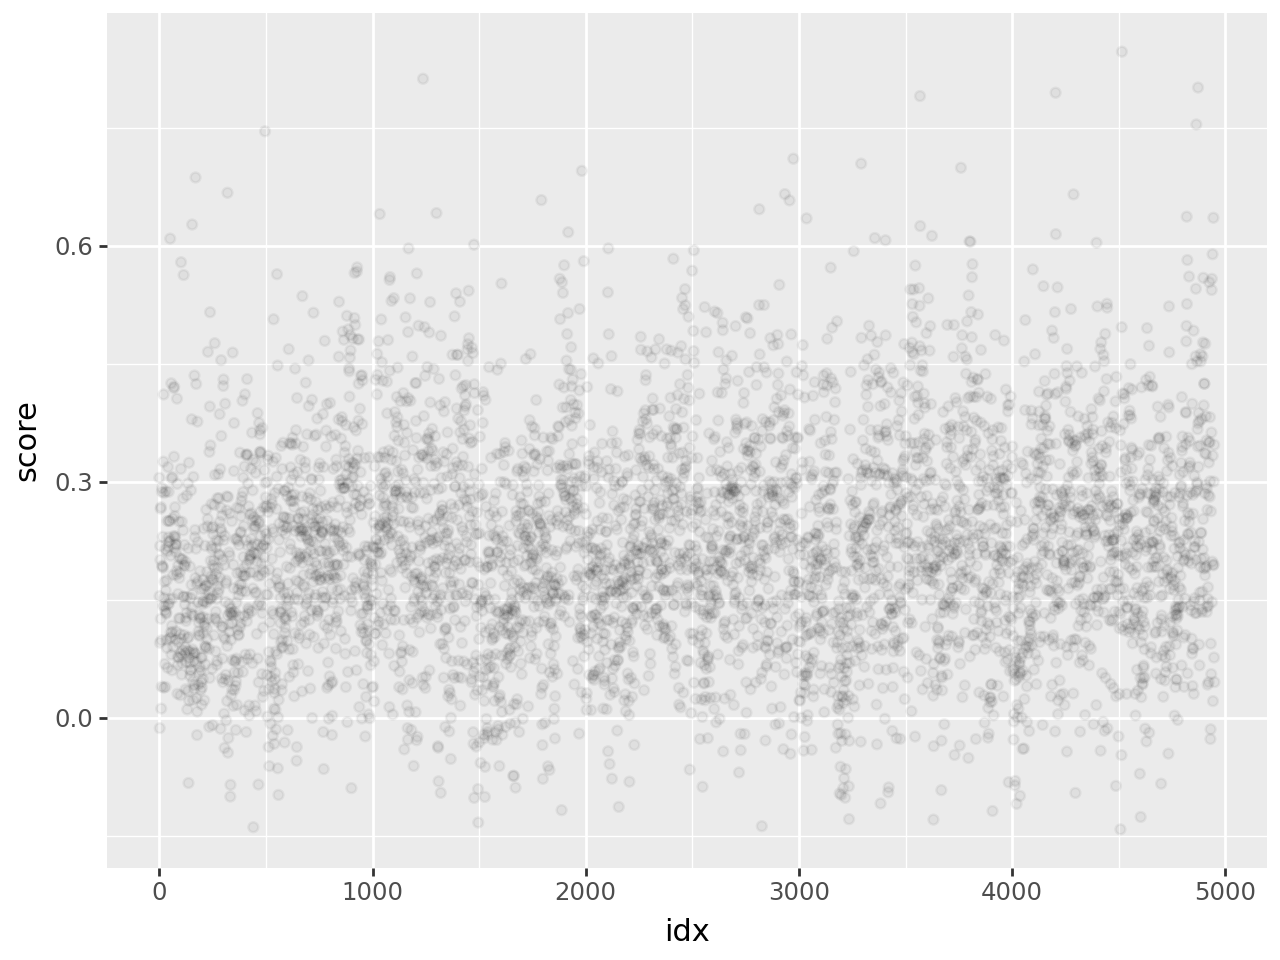

{<Figure Size: (640 x 480)>}

In [21]:
# Fix rendering of this image
from plotnine import *
{
    ggplot(comparisons, aes("idx", "score")) +
    geom_point(alpha=.05)
}

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


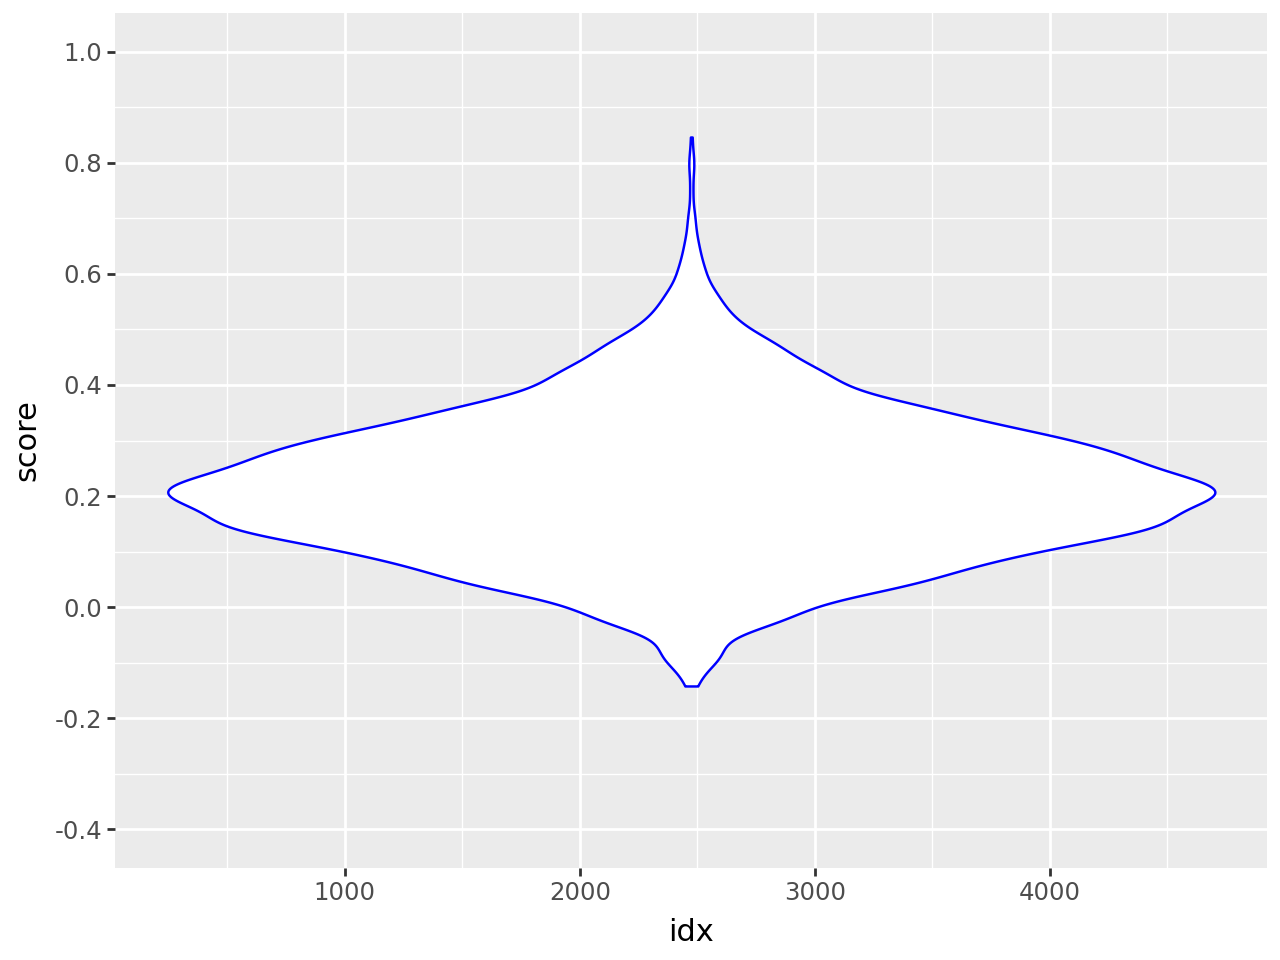

{<Figure Size: (640 x 480)>}

In [10]:
from plotnine import *
{
    ggplot(comparisons, aes("idx", "score")) +
    geom_violin(color="blue") + 
    scale_y_continuous(limits=[-0.4, 1.0], breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.17


### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [11]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
titles_index = nmslib.init(method="hnsw", space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
titles_index.addDataPointBatch(normalized_embeddings)
titles_index.createIndex(print_progress=True)

## Listing 13.18

In [12]:
#dedup these two functions from 13.3
def print_labels(prefix, matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for l, d in matches:
        print(str(int(d * 1000) / 1000), "|", l)
        
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query, convert_to_tensor=True)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        distance = distances[i] * -1
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_search(query, phrases, log=False):
    results = embedding_search(titles_index, query, phrases,
                               k=5, min_similarity=0.6)
    if log:
        print_labels(query, results)

In [13]:
semantic_search("mountain hike", titles, log=True)

0.723 | How is elevation gain and change measured for hiking trails?
0.715 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.698 | Hints for hiking the west highland way
0.694 | New Hampshire A.T. Section Hike in May? Logistics and Trail Conditions
0.678 | Long distance hiking trail markings in North America or parts thereof


## Listing 13.19
Perform vector search utilizing our configured search engine

In [14]:
cache_name = "all_outdoors_title_embeddings"

def display_results(query, search_results):
    print_labels(query, [(d["title"], d["score"])
                         for d in search_results])

def index_outdoor_title_embeddings():
    create_view_from_collection(engine.get_collection("outdoors"),
                                "outdoors")
    outdoors_dataframe = spark.sql("""SELECT id, title FROM outdoors
                                      WHERE title IS NOT NULL""")
    print(f"Calculating embeddings for {outdoors_dataframe.count()} docs.")
    ids = outdoors_dataframe.rdd.map(lambda x: x.id).collect()
    titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
    embeddings = list(map(normalize_embedding,
                          get_embeddings(titles, cache_name)))
    embeddings_dataframe = spark.createDataFrame(zip(ids, titles, embeddings),
                                   schema=["id", "title", "title_embedding"])
    
    collection = engine.create_collection("outdoors_with_embeddings")
    print(f"Writing {embeddings_dataframe.count()} docs to \"{collection.name}\" collection")
    collection.write(embeddings_dataframe)
    return collection
        
def semantic_search_with_engine(collection, query, limit=10):
    query_vector = transformer.encode(query)
    query_vector = normalize_embedding(query_vector)
    request = {"query": query_vector,
               "query_fields": ["title_embedding"],
               "return_fields": ["title", "score", "title_embedding"],
               "quantization_size": "FLOAT32",
               "limit": limit}
    response = collection.search(**request)    
    return response["docs"]

In [15]:
embeddings_collection = index_outdoor_title_embeddings()

Calculating embeddings for 5331 docs.
Wiping "outdoors_with_embeddings" collection
Creating "outdoors_with_embeddings" collection
Status: Success
Writing 5331 docs to "outdoors_with_embeddings" collection
Successfully written 5331 documents


In [16]:
query = "mountain hike"
search_results = semantic_search_with_engine(embeddings_collection, query)
display_results(query, search_results)

0.723 | How is elevation gain and change measured for hiking trails?
0.715 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.698 | Hints for hiking the west highland way
0.694 | New Hampshire A.T. Section Hike in May? Logistics and Trail Conditions
0.678 | Long distance hiking trail markings in North America or parts thereof
0.671 | How far is a reasonable distance for someone to hike on their first trip?
0.67 | Vancouver Sunrise Hike Advice?
0.668 | How to prepare on hiking routes?
0.667 | Camping on top of a mountain
0.662 | Advice for first Grand Canyon Hike for Eastern Hikers


## Listing 13.20
Rerank search results with cross-encoder

In [17]:
def rerank(results, scores):
    for i, score in enumerate(scores):
        results[i]["score"] = score
    return sorted(results, key=lambda doc: doc["score"], reverse=True)

In [18]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder(
  "cross-encoder/ms-marco-MiniLM-L-6-v2")
import torch
query = "mountain hike"
search_results = semantic_search_with_engine(
       embeddings_collection, query, limit=50)
pairs_to_score = [[query, doc["title"]]
                  for doc in search_results]
cross_scores = cross_encoder.predict(pairs_to_score,
                  activation_fct=torch.nn.Sigmoid())
search_results = rerank(search_results, cross_scores)
display_results(query, search_results[:10])

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

0.578 | What constitutes mountain exposure when hiking or scrambling?
0.337 | What are some of the winter hiking trails rated difficult in Colorado's Rocky Mountain National Park that don't require technical climbing?
0.317 | Where in the US can I find green mountains to hike like in Scotland, such as Dalveen Pass?
0.213 | Appropriate terms for activities like camping, hiking, trekking, mountaineering, wilderness survival?
0.104 | Camping on top of a mountain
0.102 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.093 | What considerations are required for making a hiking ascent of Mount Othrys, Greece
0.073 | Are there any easy hiking daytrips up mountains in Lofoten, Norway?
0.053 | First time snow hiking
0.049 | Advice for first Grand Canyon Hike for Eastern Hikers


## Figure 13.6: Visualize the titles in 3d vector space

In [19]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = numpy.array(embeddings)
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = titles_index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = titles_index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [titles[idx].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel("PCA X Label")
ax.set_ylabel("PCA Y Label")
ax.set_zlabel("PCA Z Label")
plt.show()

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 2400x1600 with 0 Axes>

Up next: [Chapter 14: Question Answering with a Fine-tuned Large Language Model](../ch14/1.question-answering-visualizer.ipynb)